In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
import itertools
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from pychromatic import Multiplot
from pychromatic.colors import accent

In [2]:
df = pd.read_csv('fe_ace_2023.10.19.02.csv')

In [23]:
def S(cc):
    return np.array([-kb*(c*np.log(c) + (1-c)*np.log(1-c)) if 1 > c > 0 else 0 for c in cc])

def fit_phase(df, lattice, temp, fitorder=3, nsteps=10000, 
              line_compound=False, 
              comp_range=None, 
              plot=False,
              entropy=False):
    
    df_lat = df[(df['phase']==lattice) & (df['temperature']==temp)]
    if not line_compound:
        if comp_range is None:
            lat_comp = np.linspace(df_lat['composition'].min(), 
                                   df_lat['composition'].max(), nsteps)
            fe_to_fit = df_lat['free_energy']
            comp_to_fit = df_lat['composition']
        else:
            lat_comp = np.linspace(comp_range[0], comp_range[1], nsteps)
            fe_to_fit = [x for count, x in enumerate(df_lat['free_energy'].values) if df_lat['composition'].values[count] <= comp_range[1]]
            comp_to_fit = [x for x in df_lat['composition'].values if x <= comp_range[1]]
        
        lat_fe_fit_func = np.polyfit(comp_to_fit, fe_to_fit, fitorder)
        lat_fe_fit = np.polyval(lat_fe_fit_func, lat_comp)
        
        if plot:
            mlt = Multiplot(width=300)
            mlt[0,0].plot(lat_comp, lat_fe_fit)
            mlt[0,0].plot(comp_to_fit, fe_to_fit, 'o')
            mlt[0,0].set_xlabel('Composition x_Li')
            mlt[0,0].set_ylabel('F')
        
        if entropy:
            if lattice == 'b32':
                lat_fe_fit = lat_fe_fit - temp*S(np.abs(lat_comp-0.5))
            else:
                lat_fe_fit = lat_fe_fit - temp*S(lat_comp)
            #if plot:
            #    plt.plot(lat_comp, lat_fe_fit, ls='dashed')

    else:
        lat_comp = df_lat['composition'].values
        lat_fe_fit = df_lat['free_energy'].values
    #print(df_lat['concentration'])
    return {'comp':lat_comp, 'fe':lat_fe_fit, 'lat': [lattice for x in range(len(lat_comp))]}

def normalize_phase(maindict, enddict, temp, nsteps=10000, 
                    line_compound=False):
    #get composition of the maindict
    comp = maindict['comp']
    
    #get endmembers
    felo = enddict['fe'][0]
    fehi = enddict['fe'][-1]
    
    cr = np.linspace(0, 1, len(comp))
    fe_linear = felo*(1-cr) + fehi*cr
    lat_fe_norm = maindict['fe'] - fe_linear
    maindict['norm'] = lat_fe_norm
    return maindict

def create_hull(dict_list, bounds):
    x1 = []
    x2 = []
    names = []
    points = []

    for count, d in enumerate(dict_list):
        args = [c for c, x in enumerate(d['comp']) if bounds[count][0] <= x <= bounds[count][1]]
        x1.append(d['comp'][args])
        x2.append(d['norm'][args])
        names.append(np.array(d['lat'])[args])

    x1 = np.hstack(x1)
    x2 = np.hstack(x2)
    names = np.hstack(names)
    points = np.column_stack((x1, x2))

    hull = ConvexHull(points)
    return hull, points

def get_endpoints(hull, points, temp):
    endpoints = []
    for simplex in hull.simplices:
        ind = points[simplex, 1]<=0.00
        xp = points[simplex, 0][ind]
        if len(xp) > 0:
            plt.plot(xp, points[simplex, 1][ind], '--', color=accent["pgrey"])
            if len(xp) == 2:
                if np.abs(xp[1]-xp[0]) > 1E-3:
                    endpoints.append([temp, xp[0]])
                    endpoints.append([temp, xp[-1]])
                    print(xp[0], xp[-1])
            #cstr = "".join(names[simplex][ind])
            xt = [temp for x in range(len(xp))]
            #plt.plot(xp, xt)
    return endpoints

def get_thermo(df, temp, fitorder=4, nsteps=10000, plot=[False, False, True], 
               plot_norm_curves=True, bounds = [[0, 0.5], [0,0.5], [0.3,0.5]]):
    lqd = fit_phase(df, 'lqd', temp, line_compound=False, comp_range=[0, 0.5], plot=plot[0])
    fcc = fit_phase(df, 'fcc', temp, line_compound=False, comp_range=[0, 0.5], plot=plot[1], entropy=True)
    b32 = fit_phase(df, 'b32', temp, line_compound=False, comp_range=[0, 0.5], plot=plot[2], entropy=True)
    #cm1 = fit_phase(df, 'al2li3', temp, line_compound=True, plot=False, entropy=False)
    #cm2 = fit_phase(df, 'al4li9', temp, line_compound=True, plot=False, entropy=False)

    lqd = normalize_phase(lqd, lqd, temp)
    fcc = normalize_phase(fcc, lqd, temp)
    b32 = normalize_phase(b32, lqd, temp)
    #cm1 = normalize_phase(cm1, lqd, temp)
    #cm2 = normalize_phase(cm2, lqd, temp)
    dict_list = [lqd, fcc, b32]

    if plot_norm_curves:
        mlt = Multiplot(width=300)
        args = [c for c, x in enumerate(lqd['comp']) if bounds[0][0] <= x <= bounds[0][1]]
        mlt[0,0].plot(lqd['comp'][args], lqd['norm'][args], label='lqd', color=accent['lblue'])
        args = [c for c, x in enumerate(fcc['comp']) if bounds[1][0] <= x <= bounds[1][1]]        
        mlt[0,0].plot(fcc['comp'][args], fcc['norm'][args], label='fcc', color=accent['lred'])
        args = [c for c, x in enumerate(b32['comp']) if bounds[2][0] <= x <= bounds[2][1]]
        mlt[0,0].plot(b32['comp'][args], b32['norm'][args], label='b32', color=accent['dyellow'])
        mlt[0,0].set_xlabel('Composition x_Li')
        mlt[0,0].set_ylabel('F')
        mlt[0,0].set_ylim(top=0.0)
        mlt[0,0].set_xlim(0, 0.5)
        mlt[0,0].legend(frameon=False)
    
    hull, points = create_hull(dict_list, bounds)
    endpoints = get_endpoints(hull, points, temp)
    return endpoints

/tmp/ipykernel_30054/3479983280.py:22: RankWarning: Polyfit may be poorly conditioned
  lat_fe_fit_func = np.polyfit(comp_to_fit, fe_to_fit, fitorder)


0.18971897189718973 0.4480948094809481
0.4857985798579858 0.5
0.10966096609660966 0.048854885488548855


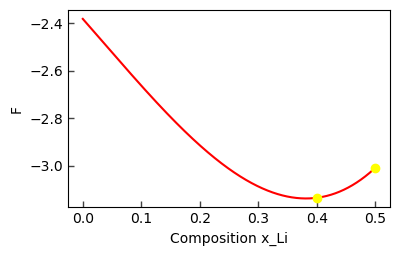

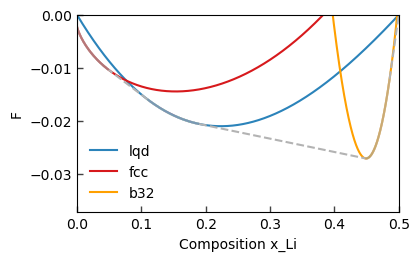

In [68]:
points = get_thermo(df, 850)

In [62]:
for point in points:
    collected_points.append(point)

In [70]:
t, c = np.loadtxt('thermo.data', unpack=True)

Text(0, 0.5, 'Temperature')

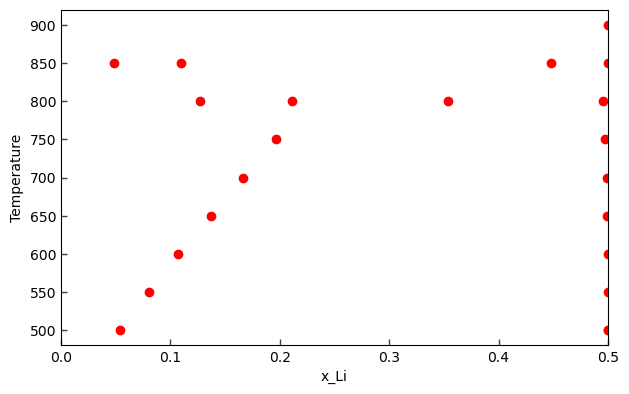

In [82]:
mlt =Multiplot()
mlt[0,0].scatter(t, c)
mlt[0,0].set_xlim(0,0.5)
mlt[0,0].set_xlabel('x_Li')
mlt[0,0].set_ylabel('Temperature')